## My version of this notebook 

We will be using ray to develop the appplication using distributed workloads

Importing all necessary libraries

In [1]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import ray
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-08-25 15:53:15,513	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.3
Ray version:,2.6.0
Dashboard:,http://127.0.0.1:8265


Since I am going to be running this locally, my cpu will be acting as the node

In [3]:
ray.cluster_resources()

{'CPU': 16.0,
 'node:__internal_head__': 1.0,
 'node:10.0.0.77': 1.0,
 'object_store_memory': 3440068608.0,
 'memory': 6880137216.0}

In [4]:
num_workers = 10
resources_per_worker = {"CPU": 3, "GPU": 1}

### Data Ingestion -> Going through the data and analysing all its aspects

In [5]:
URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(URL)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


Checking whether the data integrity has been maintained by looking for 
null values, checking if all the tags belong in the set of tags that we wanted,etc

In [6]:
df.isna().sum()

id             0
created_on     0
title          0
description    0
tag            0
dtype: int64

We can see that there are no null values

In [7]:
df.tag.unique()

array(['computer-vision', 'other', 'natural-language-processing', 'mlops'],
      dtype=object)

We can see that the data is as we want it, with all the features we want.
We can move on to the next part

### Data Splitting

In [8]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

The number of content we have for each tag differs, this could cause a bias in the model picking one tag over another, normally in such a case, the model picks the tag that has been shown to it the most. To fix this, we need to fix the way we feed in data, and make sure that we have equal/proprtional features of each in the training and validation set 

In [9]:
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size)

In [10]:
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [15]:
val_df.tag.value_counts() * int((1-test_size)/test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

We will now try and understand the data in a deeper fashion

In [17]:
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

Plotting the tag frequencies

### tags,tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10,3))
ax = sns.barplot(x=list(tags),y=list(tag_counts))
ax.set_xticklabels(tags,rotation=0,fontsize=12)
plt.title("Tag Distribution",fontsize=16)
plt.ylabel("Number of projects",fontsize=14)
plt.show()

There is a huge data imbalance, this would cause issues during the training

Generating a Word cloud

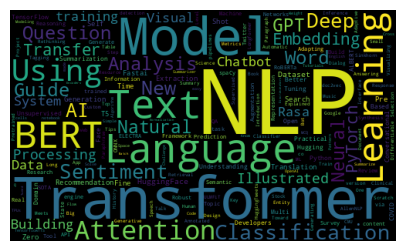

In [18]:
tag = "natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag == tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)